In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from cv.data.cifar100 import CLASSES
from cv.data.dataset import CIFAR100
import albumentations as A
from cv.utils.config import parse_config
import torch
from cv.utils.build import build_model
from cv.data.transforms import make_classification_eval_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from cv.data.transforms import get_shift_transforms


%config InlineBackend.figure_formats = ['retina']

In [2]:
DATA_DIR = Path("/raid4/datasets")

In [3]:
train_dataset = CIFAR100(root=DATA_DIR, train=True)

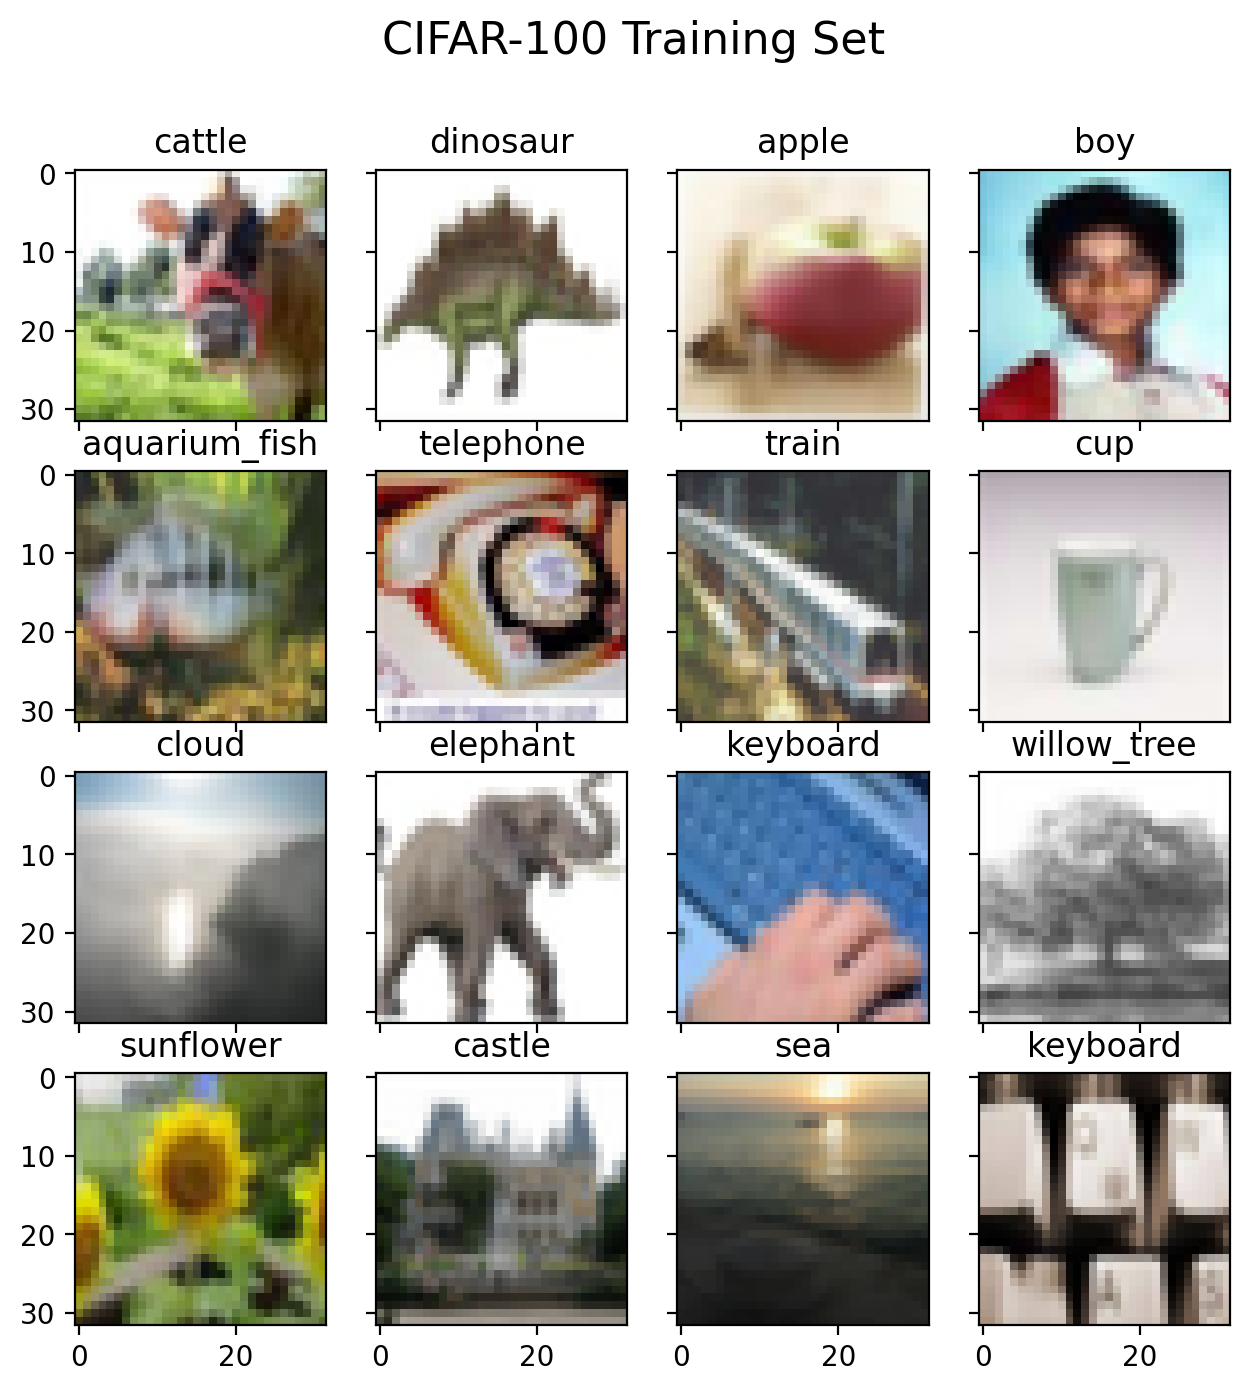

In [4]:
fig = plt.figure(figsize=(7.5, 7.5))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
    axes_pad=0.25,  # pad between Axes in inch.
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

for i, ax in enumerate(grid):
    image, label = train_dataset[i]
    ax.imshow(image)
    ax.set_title(CLASSES[label])

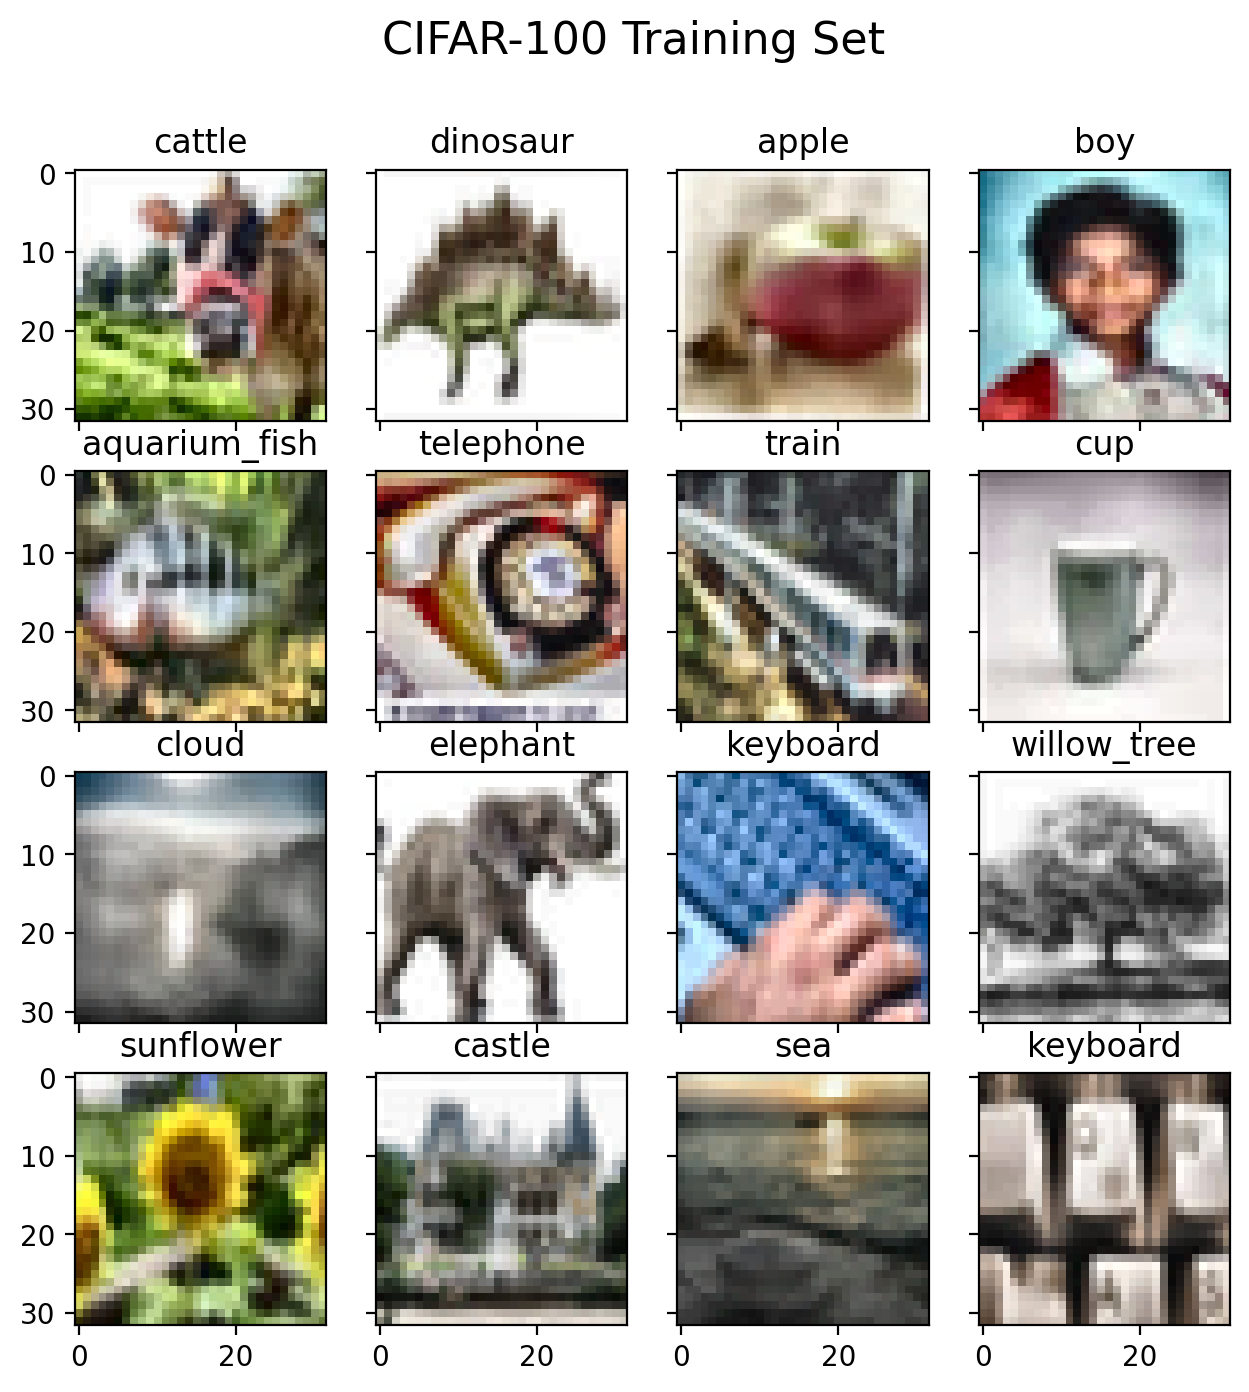

In [5]:
fig = plt.figure(figsize=(7.5, 7.5))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
    axes_pad=0.25,  # pad between Axes in inch.
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

normalize = A.CLAHE(p=1.0, tile_grid_size=(4, 4))

for i, ax in enumerate(grid):
    image, label = train_dataset[i]
    image = normalize(image=image)["image"]
    ax.imshow(image)
    ax.set_title(CLASSES[label])

In [6]:
ood_dataset = np.load(DATA_DIR.joinpath("cifar-100-ood", "distortion00.npy"))

In [7]:
idx = [9999, 19999, 29999, 39999, 49999]

In [8]:
ood_sample_dataset = ood_dataset[idx]

In [9]:
ood_sample_dataset.shape

(5, 32, 32, 3)

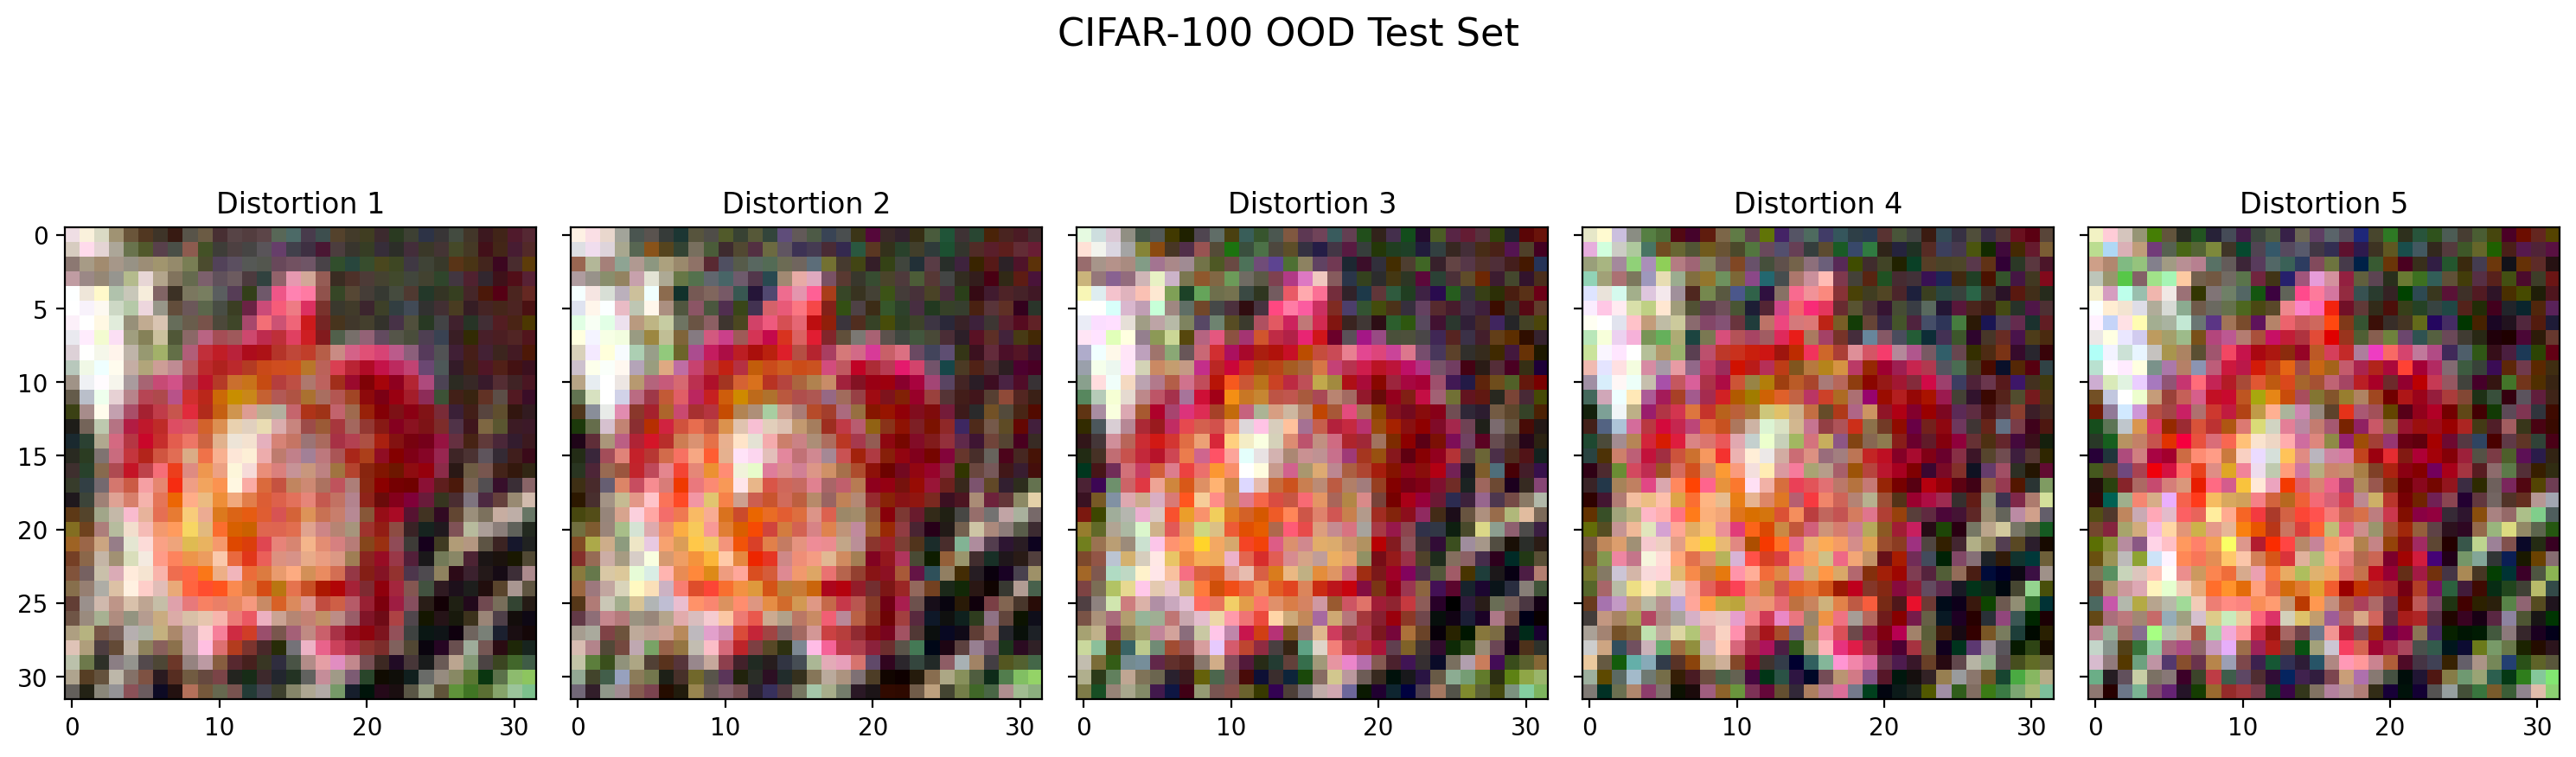

In [10]:
fig, axs = plt.subplots(
    1, 5, figsize=(15, 5), sharey=True, sharex=True, tight_layout=True
)

fig.suptitle("CIFAR-100 OOD Test Set", fontsize=16)

for i, ax in enumerate(axs.ravel()):
    image = ood_sample_dataset[i]
    ax.imshow(image)
    ax.set_title(f"Distortion {i + 1}")


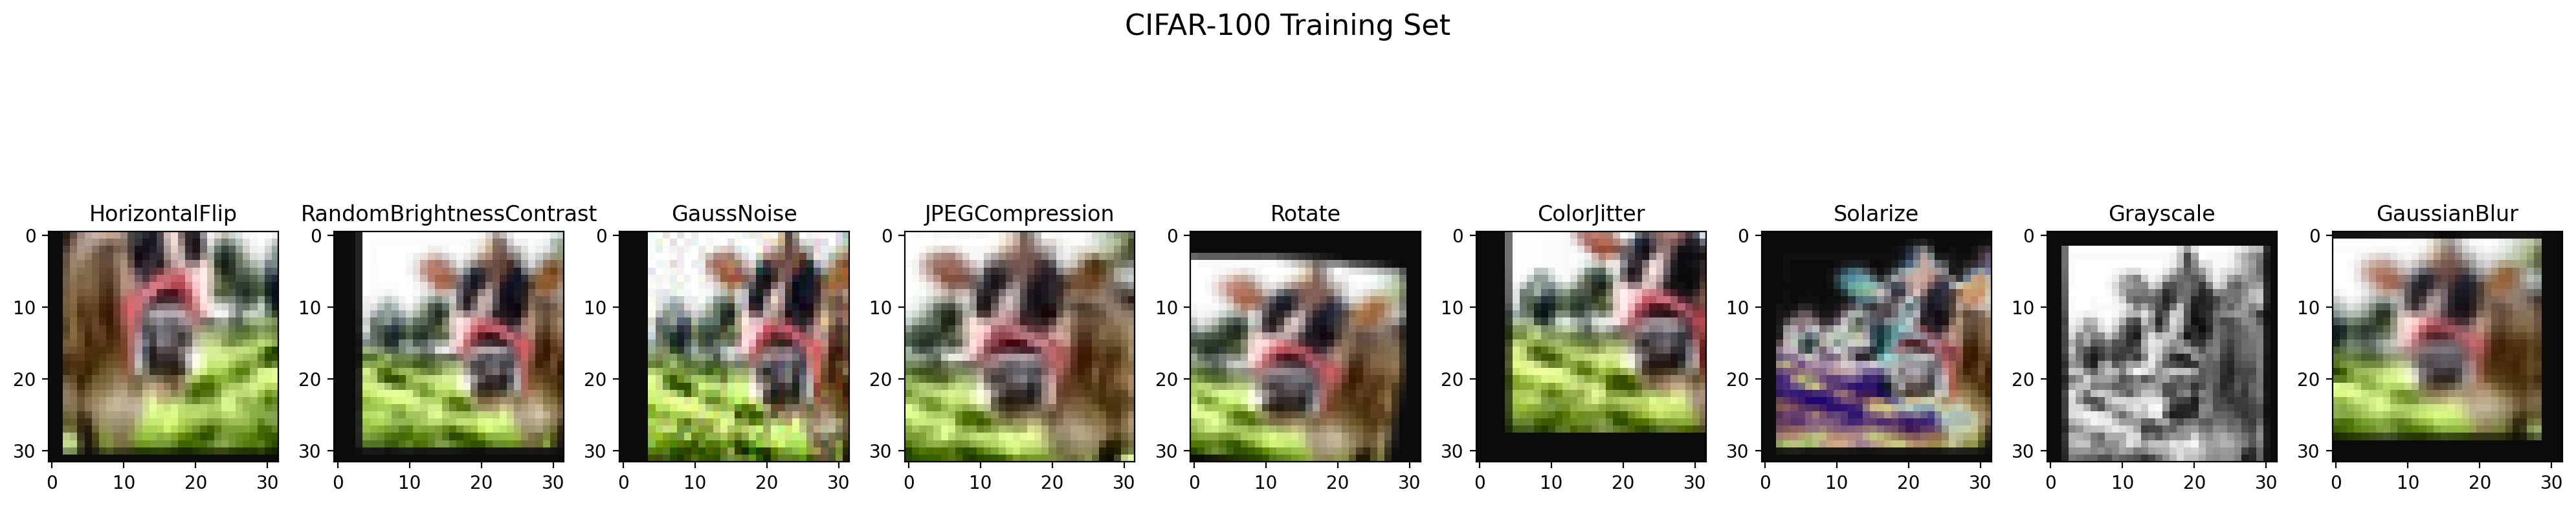

In [11]:
base_transforms = A.Compose(
    [
        A.Pad(p=1.0, padding=4),
        A.RandomResizedCrop(p=1.0, scale=(0.32, 1.0), size=(32, 32)),
        A.CLAHE(p=1.0, tile_grid_size=(4, 4)),
    ]
)
transforms = {
    "HorizontalFlip": A.HorizontalFlip(p=1.0),
    "RandomBrightnessContrast": A.RandomBrightnessContrast(p=1.0),
    "GaussNoise": A.GaussNoise(p=1.0, mean_range=(0.0, 0.0), std_range=(0.025, 0.1)),
    "JPEGCompression": A.ImageCompression(p=1.0, quality_range=(90, 99)),
    "Rotate": A.Rotate(p=1.0, limit=(-15, 15)),
    "ColorJitter": A.ColorJitter(
        p=1.0, brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1
    ),
    "Solarize": A.Solarize(p=1.0, threshold_range=(0.5, 0.5)),
    "Grayscale": A.ToGray(p=1.0),
    "GaussianBlur": A.GaussianBlur(p=1.0, sigma_limit=(0.1, 2.0)),
}
fig, axs = plt.subplots(
    1,
    len(transforms),
    figsize=(20, 5),
    tight_layout=True,
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

image, label = train_dataset[0]

for i, (name, t) in enumerate(transforms.items()):
    im = base_transforms(**t(image=image))["image"]
    axs[i].imshow(im)
    axs[i].set_title(name)

In [30]:
shifts = [i for i in range(1, 3)]
transforms = get_shift_transforms(shifts, "Moore")

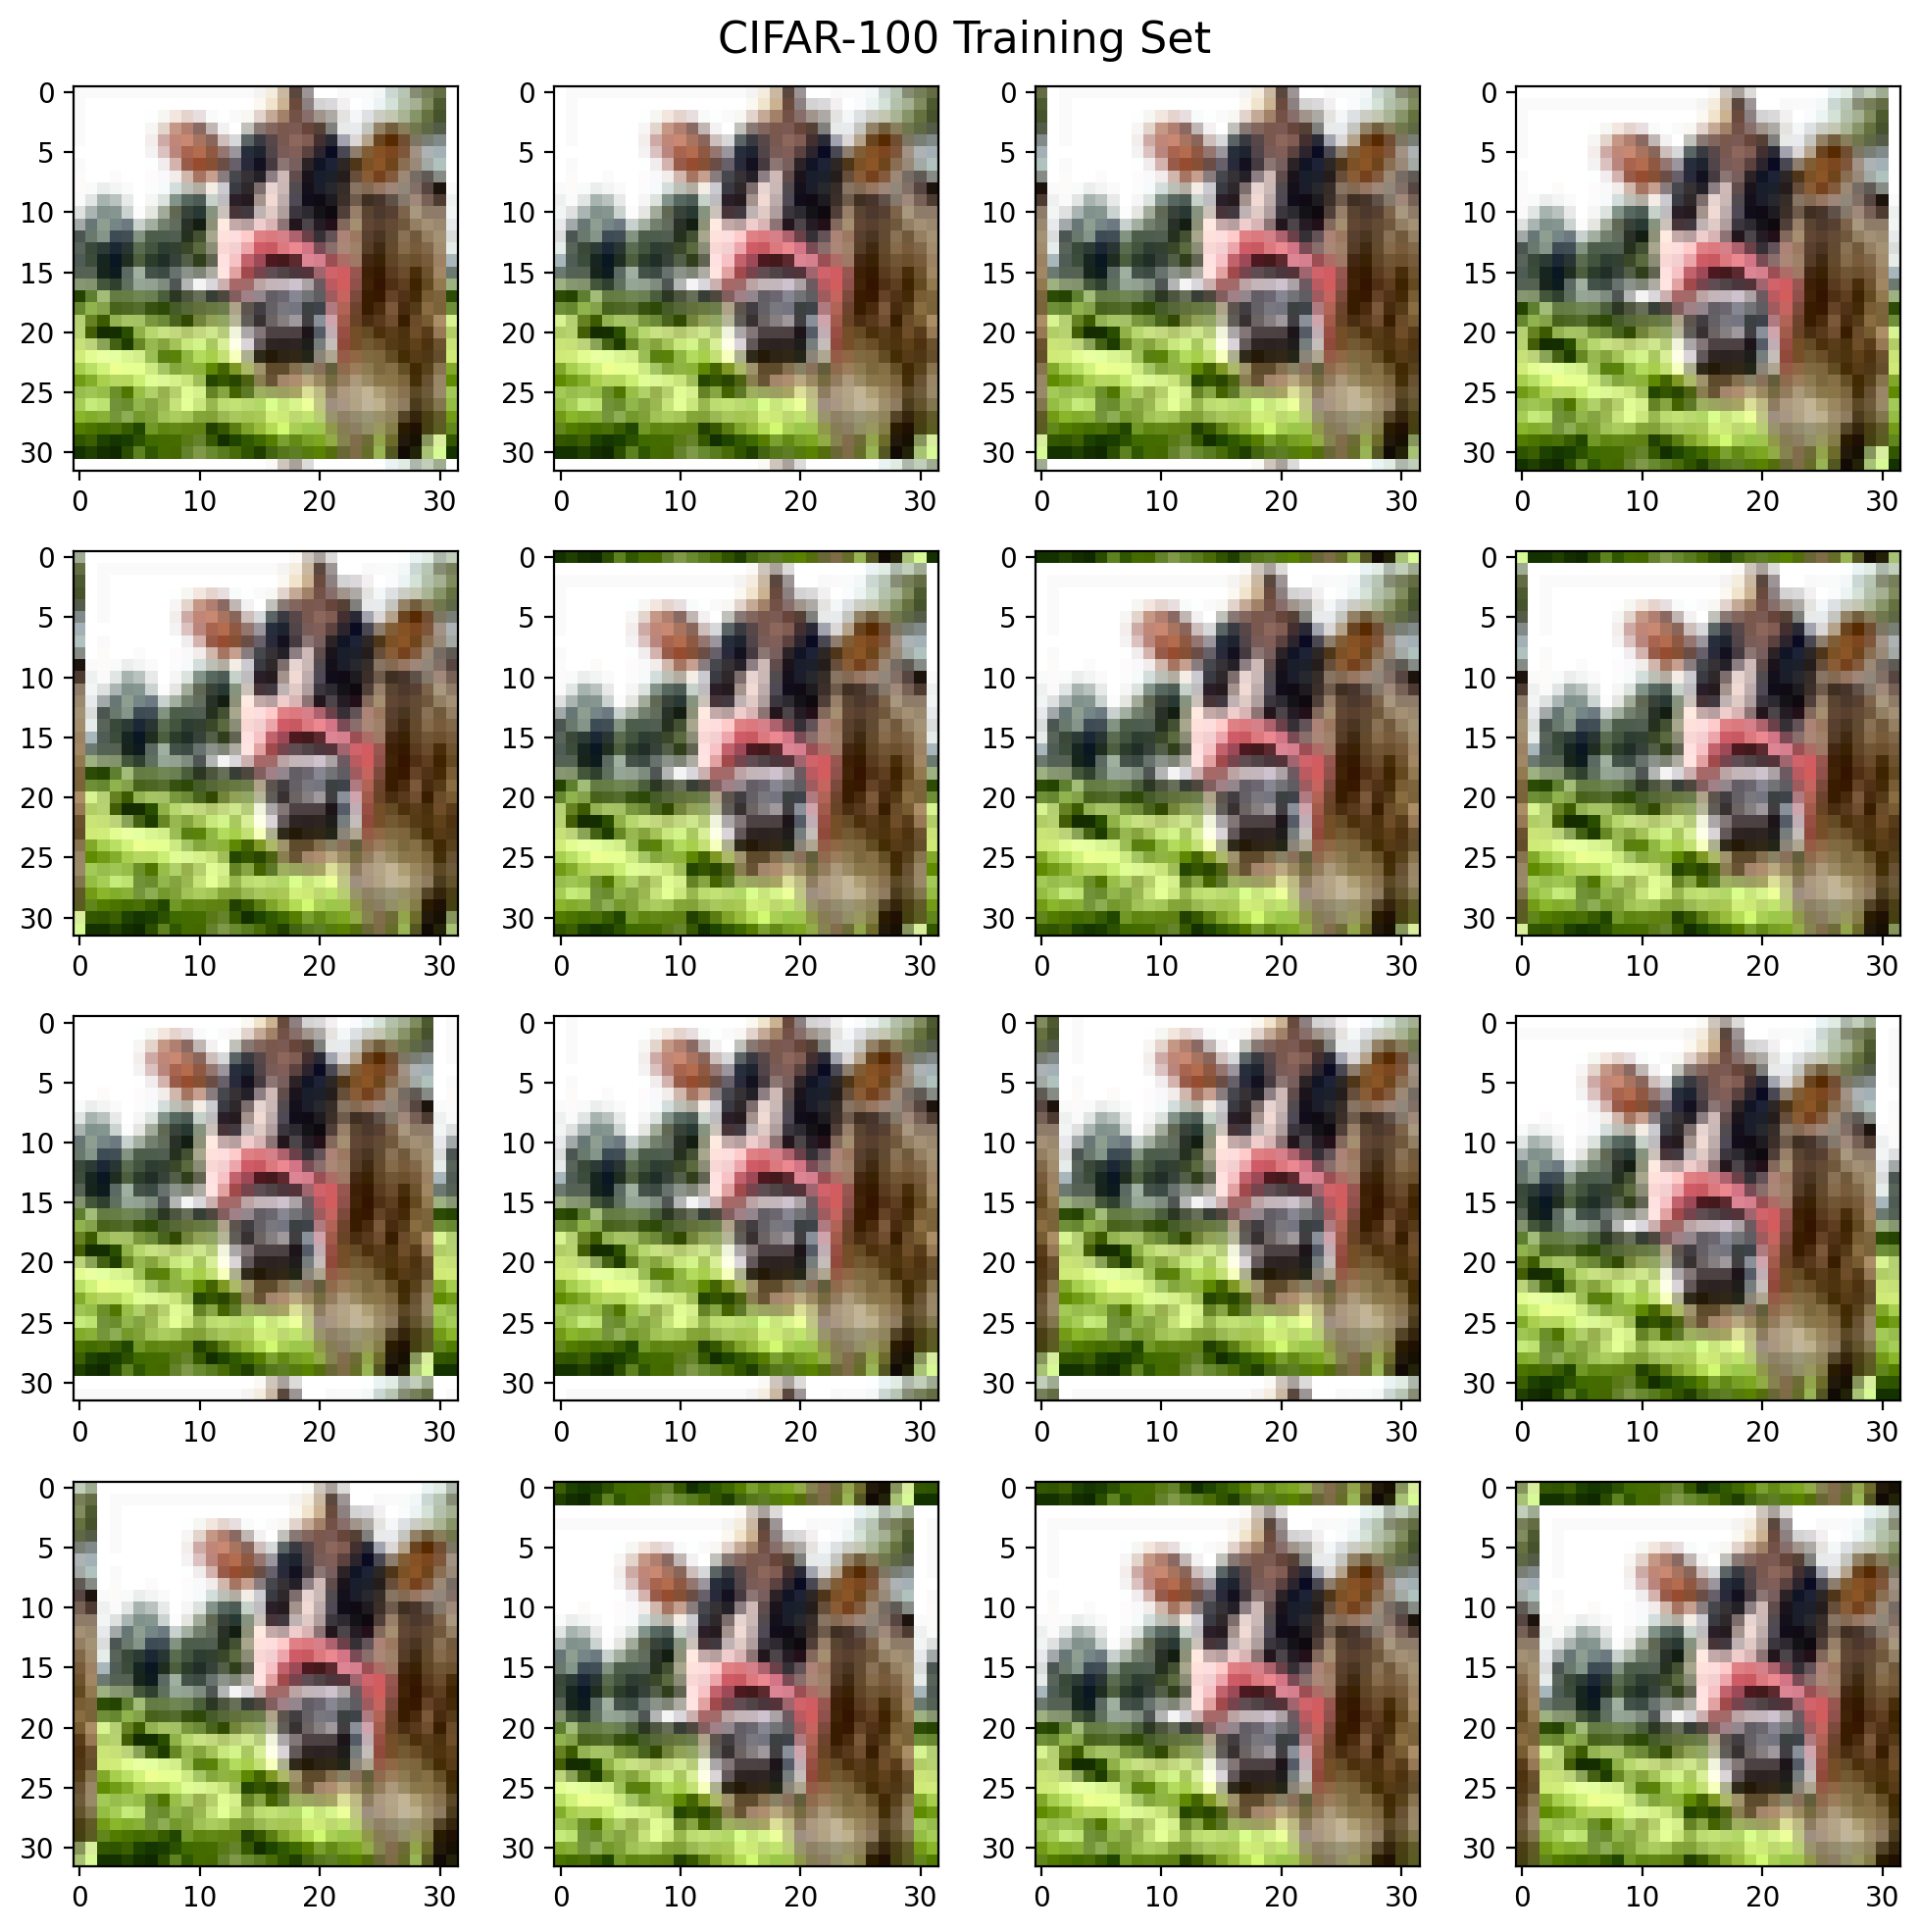

In [31]:
base_transforms = A.Compose(
    [
        A.CLAHE(p=1.0, tile_grid_size=(4, 4)),
        A.ToTensorV2(),
    ]
)
fig, axs = plt.subplots(
    4,
    4,
    figsize=(10, 10),
    tight_layout=True,
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

image, label = train_dataset[0]

for i, ax in enumerate(axs.ravel()):
    im = transforms[i](base_transforms(image=image)["image"])
    im = im.permute(1, 2, 0).cpu().numpy()
    ax.imshow(im)